# Tuto classe Model

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("../scripts/")

# librairies perso
from model_objet import Model
from import_data import import_data
from metrics import tab_mesure
from display import display_mesure

In [2]:
data = import_data()

def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/gasNat.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 37, 38 , 49]))]

Le constructeur de la classe Model prend plusieurs paramètres : 
   - un dataFrame
   - les variables de la régression
   - les étiquettes associées 
   - lim_date : pourcentage des variables d'entrainement
   - group (bool) permet de savoir si on fait un modèle pour chaque client ou un modèle global 
   - random_forest (bool) si on fait un un modèle par random_forest

In [3]:
Model1 = Model(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], 0.8, False, False)

In [4]:
# On peut accéder aux variables de la classe : 
Model1.xargs, Model1.yargs

(['id_client', 'forecasted_consumption', 'CAC'], ['real_consumption'])

Ensuite on peut générer le modèle associé à notre classe (une régression linéaire dans ce cas)

In [5]:
Model1.generate_model()

In [6]:
Model1.model

LinearRegression()

La régression n'est à ce stade pas "entrainée", on peut alors créer les données d'entrainement. Avant cela on va choisir la meilleur lim_date 

In [7]:
Model1.best_lim_date()

(0.66, 0.85, 0.66)

In [8]:
Model1.lim_date = 0.66

In [9]:
# création des donnnées d'entrainement 
Model1.generate_train_set()

In [10]:
Model1.x_test

,id_client,forecasted_consumption,CAC
502,1,8400.0,6440.299805
503,1,8400.0,6279.689941
504,1,8400.0,6305.459961
505,1,8400.0,6305.459961
506,1,8400.0,6305.459961
...,...,...,...
36522,48,0.0,7085.470215
36523,48,0.0,7085.470215
36524,48,0.0,7085.470215
36525,48,0.0,7054.240234


On peut alors entrainer le modèle

In [11]:
Model1.train_model()

Une fois entrainer, on peut appliquer le modèle aux données d'entrainement

In [12]:
Model1.test_model()

In [13]:
Model1.y_pred

array([7783.01991819, 7777.08184839, 7778.03461788, ...,  785.4521147 ,
        784.29747947,  785.0683315 ])

On peut alors estimer les performances

In [14]:
Model1.performance_indicator()

In [15]:
Model1.evaluation_model

[(0.8605178992415794, 3227313.8388770223, 1061.2435421282578),
 (0.5157825280970922, 38099285.761255145, 5001.79715006223),
 (0.9493860783033021, 27615536.712444797, 3704.1133637927837),
 (0.821085793845964, 4195494.367642388, 1416.2175994986953),
 (0.06865656735153643, 212724.95248305023, 371.8865548044637),
 (0.5652385588570892, 83965848.54134192, 6744.884263149263),
 (0.9324983957640448, 76600802.41155723, 3615.2174504259206),
 (0.6598024245359364, 42439965.197717465, 4773.437070481648),
 (0.05771125472380694, 206727.79998194653, 418.09026707318185),
 (0.8224444041088168, 36473.47022693927, 190.2751392665765),
 (0.32533763130905746, 475869.7793983121, 551.0789311761508),
 (0.5141591349288681, 34324.03527657119, 170.82251170115947),
 (0.03999927701265977, 8666.749148078583, 89.72660298450012),
 (0.22688051851953359, 4752752.921460441, 1535.6556277972877),
 (0.890082962815801, 10614749.432239974, 1807.63839080266),
 (0.4126687303345561, 9279.303934414293, 72.63877826298744),
 (0.37493

Pour mieux y voir 

In [16]:
tab_mesure(Model1.evaluation_model).describe()

,R2,MSE,MAE
count,41.000000,4.100000e+01,41.000000
mean,0.447890,9.080077e+06,1315.400536
std,0.307560,1.970721e+07,1624.663941
min,0.001426,8.666749e+03,72.638778
25%,0.146026,1.787847e+05,371.886555
50%,0.449234,4.899240e+05,603.771836
75%,0.711403,3.872201e+06,1416.217599
max,0.949386,8.396585e+07,6744.884263


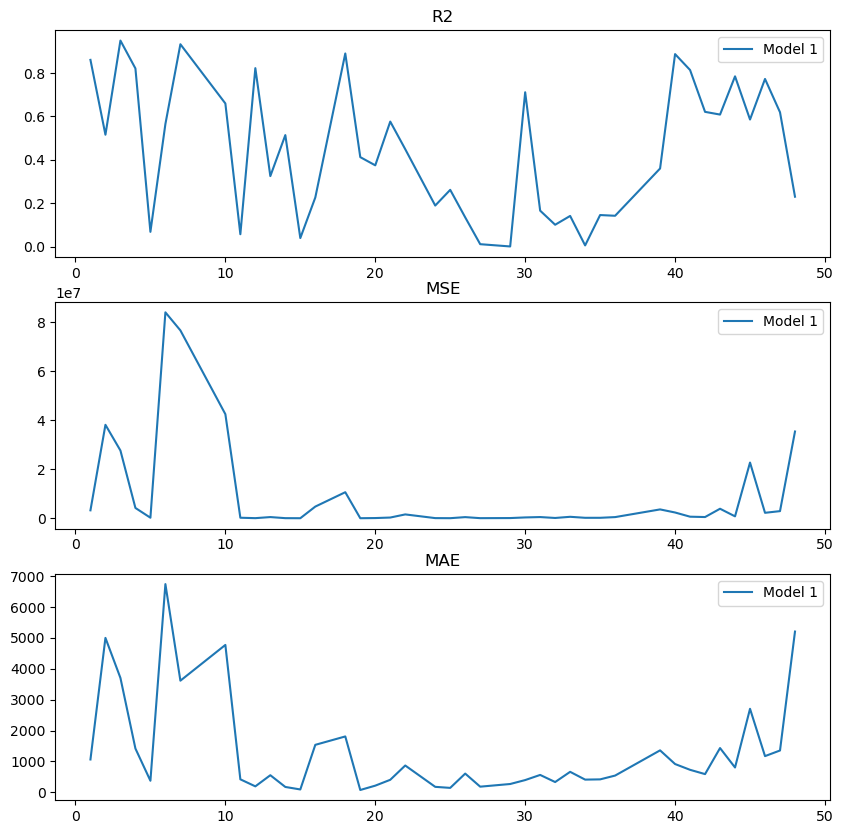

In [17]:
display_mesure(Model1.df, [Model1.evaluation_model], ["Model 1"]);

### Pour aller plus vite 

On peut utiliser directement la méthode complet_process pour aller plus rapidement 

In [18]:
Model2 = Model(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], 0.8, False, False)

In [19]:
Model2.complet_process()

In [20]:
tab_mesure(Model2.evaluation_model).describe()

,R2,MSE,MAE
count,41.000000,4.100000e+01,41.000000
mean,0.447890,9.080077e+06,1315.400536
std,0.307560,1.970721e+07,1624.663941
min,0.001426,8.666749e+03,72.638778
25%,0.146026,1.787847e+05,371.886555
50%,0.449234,4.899240e+05,603.771836
75%,0.711403,3.872201e+06,1416.217599
max,0.949386,8.396585e+07,6744.884263


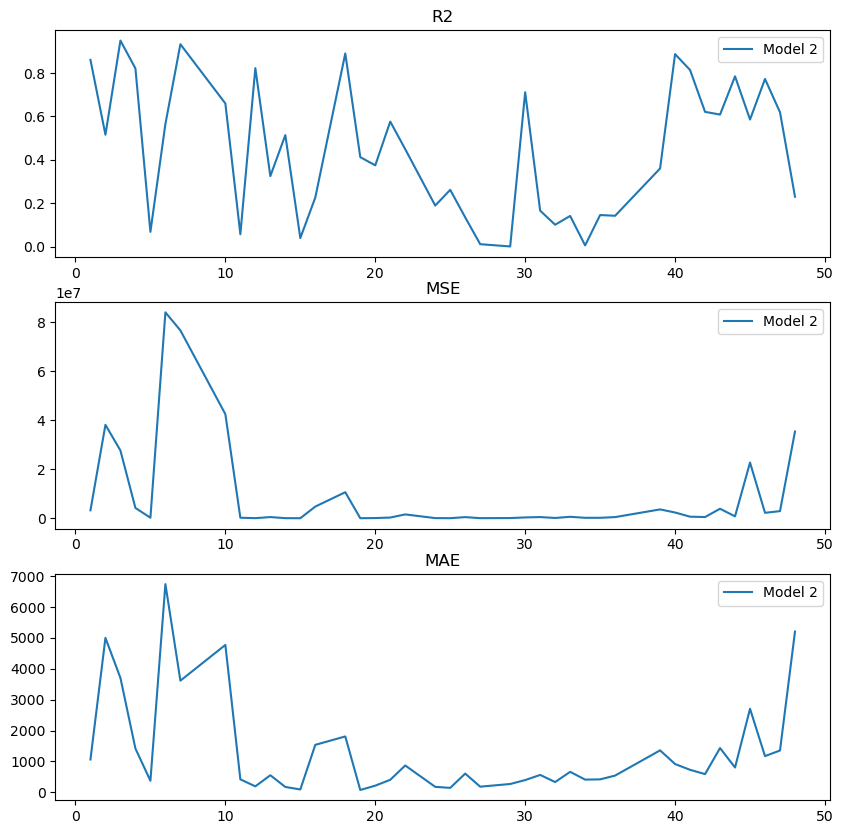

In [21]:
display_mesure(Model2.df, [Model2.evaluation_model], ["Model 2"]);